## 1. Configuración Inicial e Importación de Bibliotecas

En esta sección configuramos el entorno de trabajo e importamos las bibliotecas necesarias.

In [1]:
# Instalación (si es necesario)
# !pip install enahopy


import enahopy


# ========== USANDO ENAHOPY ENAHO LOADER ==========
from enahopy.loader import ENAHODataDownloader
from enahopy.loader.io import ENAHOLocalReader # si necesitas leer el archivo descargado


# ========== USANDO ENAHOPY's ENAHOModuleMerger ==========
from enahopy.merger import ENAHOModuleMerger
from enahopy.merger.config import ModuleMergeConfig, ModuleMergeLevel
import logging


# ========== USANDO ENAHOPY ENAHO NULL_ANALYSIS ==========
from enahopy.null_analysis import ENAHONullAnalyzer

import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


warnings.filterwarnings('ignore')

print(f"enahopy versión: {enahopy.__version__}")
print(f"Inicio del análisis: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

enahopy versión: 1.0.0
Inicio del análisis: 2025-11-24 14:37:13


In [2]:
# ========== CONFIGURACIÓN ENAHOModuleMerger ==========

# Configurar el merger para nivel individual (persona)
config = ModuleMergeConfig(merge_level=ModuleMergeLevel.PERSONA)
logger = logging.getLogger('enaho_merger')
merger = ENAHOModuleMerger(config, logger)


# Configurar el merger para nivel hogar
config_hogar = ModuleMergeConfig(merge_level=ModuleMergeLevel.HOGAR)
merger_hogar = ENAHOModuleMerger(config_hogar, logger)




In [3]:
# Función para promedio ponderado
def weighted_avg(group, avg_col, weight_col):
    d = group[avg_col]
    w = group[weight_col]
    return (d * w).sum() / w.sum() if w.sum() != 0 else 0


## 2. Descarga y Carga de Datos ENAHO

### 2.1  Módulos ENAHO Utilizados

La **ENAHO** está organizada en distintos **módulos temáticos**.
Para este análisis se emplean los siguientes:

| **Módulo** | **Descripción**                            | **Nivel de Análisis** | **Variables Clave**                            |
|:----------:|:-------------------------------------------|:----------------------|:-----------------------------------------------|
|   **01**   | Características de la vivienda y del Hogar | Persona | Servicios básicos, Materiales del hogar, etc.  |
|   **34**   | Sumarias (Variables Calculadas)            | Hogar | Pobreza, ingreso total, tamaño del hogar, etc. |

---

### 2.2  Proceso de Descarga

Se utilizó la biblioteca **`enahopy`** para **descargar y gestionar automáticamente los datos** desde los servidores oficiales del **INEI**.
Este proceso garantiza la **trazabilidad, consistencia y actualización** de los archivos utilizados en el análisis.

>  *`enahopy` permite automatizar la descarga, validación y lectura de los módulos ENAHO en diferentes formatos, facilitando un flujo de trabajo reproducible y auditable.*

---



In [4]:
print("\n" + "="*70)
print(" DESCARGA DE MÚLTIPLES MÓDULOS: 2024 ".center(70))
print("="*70 + "\n")

# Módulos a descargar
modulos_interes = {
    "01": "Caracteristica de la vivienda y del hogar",
    "34": "Sumarias ( Variables Calculadas )",
}

downloader = ENAHODataDownloader(verbose=True)

print("Módulos a descargar:")
for code, desc in modulos_interes.items():
    print(f"  {code}: {desc}")

# Descarga múltiple
data_multi = downloader.download(
    modules=list(modulos_interes.keys()),
    years=["2024"],
    output_dir=r"E:\papx\end_to_end_ml\nb_pr\enahopy\examples\medium\data",
    decompress=True,
    only_dta=True,
    load_dta=True,
    parallel=True,                    # ¡Descarga paralela!
    max_workers=2,                    # 2 módulos en paralelo
    verbose=False
)




                 DESCARGA DE MÚLTIPLES MÓDULOS: 2024                  

2025-11-24 14:37:14 | INFO     | enahopy | ENAHOPY logging initialized
2025-11-24 14:37:14 | DEBUG    | enahopy.loader.core.cache | No expired cache entries to clean
Módulos a descargar:
  01: Caracteristica de la vivienda y del hogar
  34: Sumarias ( Variables Calculadas )
2025-11-24 14:37:49 | INFO     | enaho_downloader | Archivo cargado: enaho01-2024-100.dta (44731 filas)
2025-11-24 14:37:54 | INFO     | enaho_downloader | Archivo cargado: sumaria-2024-12g.dta (33691 filas)
2025-11-24 14:37:56 | INFO     | enaho_downloader | Archivo cargado: sumaria-2024.dta (33691 filas)
2025-11-24 14:37:56 | DEBUG    | enahopy.loader.core.cache | Cache updated for key: last_download_session
2025-11-24 14:37:56 | INFO     | enahopy.performance.enahopy.loader.io.main.download | Function download executed in 42.3666s


### 2.3 Verificación de Datos DescargadosVerificamos que todos los módulos se hayan descargado correctamente y revisamos sus dimensiones.

In [5]:
for (año, modulo), archivos_dict in data_multi.items():
    print(f"\n Año: {año}, Módulo: {modulo}")
    for nombre_archivo, df in archivos_dict.items():
        print(f"  - Nombre: '{nombre_archivo}', Dimensiones: {df.shape}")


 Año: 2024, Módulo: 01
  - Nombre: 'enaho01-2024-100', Dimensiones: (44731, 338)

 Año: 2024, Módulo: 34
  - Nombre: 'sumaria-2024-12g', Dimensiones: (33691, 242)
  - Nombre: 'sumaria-2024', Dimensiones: (33691, 163)


---
## 3. Selección de Variables de Interés
### 3.1 Variables del Módulo 34 (Sumarias - Nivel Hogar). Seleccionamos variables clave a nivel de hogar que incluyen:
- **Identificadores:** `conglome`, `vivienda`, `hogar`
-  **Variables de pobreza:** `pobreza` (categoría oficial INEI)
-  **Variables económicas:** `inghog2d` (ingreso total), `gashog2d` (gasto total)
-  **Composición del hogar:** `mieperho` (número de miembros)
-  **Geográficas:** `dominio` (región natural), `estrato`
-  **Factor de expansión:** `factor07` (para estimaciones poblacionales)
### 3.2 Estas variables nos permiten:
- 1. Identificar el nivel de pobreza oficial (INEI)
- 2. Calcular indicadores económicos del hogar
- 3. Controlar por características demográficas
- 4. Realizar estimaciones representativas a nivel nacional

In [7]:
sumaria_vars = [
    'conglome',
    'vivienda',
    'hogar',
    'ubigeo',
    'pobreza',
    'inghog2d',
    'mieperho',
    'dominio',
    'estrato',
    'factor07'
]

carac_hogar_vars = [
    'conglome',
    'vivienda',
    'hogar',
    'p101',
    'p102',
    'p103',
    'p103a',
    'p104b1',
    'p110',
    'p111a',
    'i105b',
    'nbi1',
    'nbi2',
    'nbi3',
    'nbi4',
    'nbi5'
]

In [9]:
data_caracteristica_vivienda = data_multi[('2024', '01')]['enaho01-2024-100']
data_sumaria = data_multi[('2024', '34')]['sumaria-2024']
data_carac_viv = data_caracteristica_vivienda[carac_hogar_vars]
data_sum = data_sumaria[sumaria_vars]

In [11]:
print("\n" + "=" * 70)
print(" PASO 3: UNIR CON SUMARIA (BASE A NIVEL HOGAR) ".center(70))
print("=" * 70 + "\n")

print("Uniendo datos agregados con sumaria (módulo 34)...")
print(f"   Base (sumaria): {data_sum.shape[0]:,} hogares")
print(f"   Datos agregados: {data_carac_viv.shape[0]:,} hogares")


# Realizar el merge usando enahopy
print("\n Usando ENAHOModuleMerger de enahopy para fusionar sumaria con caracteristicas de la vivienda y hogar...")
merge_result_hogar = merger_hogar.merge_modules(
    left_df=data_sum,           # Sumaria como base (left)
    right_df=data_carac_viv,         # Datos agregados (right)
    left_module='34',           # Módulo sumaria
    right_module='01',    # Identificador para datos agregados
    merge_config=config_hogar
)



            PASO 3: UNIR CON SUMARIA (BASE A NIVEL HOGAR)             

Uniendo datos agregados con sumaria (módulo 34)...
   Base (sumaria): 33,691 hogares
   Datos agregados: 44,731 hogares

 Usando ENAHOModuleMerger de enahopy para fusionar sumaria con caracteristicas de la vivienda y hogar...

            PASO 3: UNIR CON SUMARIA (BASE A NIVEL HOGAR)             

Uniendo datos agregados con sumaria (módulo 34)...
   Base (sumaria): 33,691 hogares
   Datos agregados: 44,731 hogares

 Usando ENAHOModuleMerger de enahopy para fusionar sumaria con caracteristicas de la vivienda y hogar...


In [13]:
# Extraer el DataFrame resultante
data_final = merge_result_hogar.merged_df

# Analizar resultado del merge usando la información de enahopy
print("\n" + "=" * 70)
print(f" MERGE FINAL COMPLETADO - NIVEL HOGAR (usando enahopy)")
print("=" * 70)
print(f"   Total de hogares: {len(data_final):,}")
print(f"   Total de columnas: {data_final.shape[1]}")
print(f"   Quality score: {merge_result_hogar.quality_score:.1f}%")
print(f"   Conflictos resueltos: {merge_result_hogar.conflicts_resolved}")
print(f"   Registros no matcheados (left): {merge_result_hogar.unmatched_left}")
print(f"   Registros no matcheados (right): {merge_result_hogar.unmatched_right}")

# Comparar n_personas_contadas con mieperho (de sumaria)
if 'mieperho' in data_final.columns and 'n_personas_contadas' in data_final.columns:
    diff = (data_final['mieperho'] - data_final['n_personas_contadas']).abs()
    print(f"\n📊 Validación de conteo de personas:")
    print(f"   Diferencia promedio entre mieperho y conteo: {diff.mean():.2f}")
    print(f"   Hogares con conteo exacto: {(diff == 0).sum():,}")

print("\n📋 Primeras filas del dataset final (nivel hogar):")
data_final.head(3)


 MERGE FINAL COMPLETADO - NIVEL HOGAR (usando enahopy)
   Total de hogares: 33,691
   Total de columnas: 23
   Quality score: 100.0%
   Conflictos resueltos: 0
   Registros no matcheados (left): 0
   Registros no matcheados (right): 0

📋 Primeras filas del dataset final (nivel hogar):


,conglome,vivienda,hogar,ubigeo,pobreza,inghog2d,mieperho,dominio,estrato,factor07,...,p103a,p104b1,p110,p111a,i105b,nbi1,nbi2,nbi3,nbi4,nbi5
0,015009,013,11,010101,no pobre,52162.609375,2,sierra norte,de 20 000 a 49 999 habitantes,79.816757,...,concreto armado,si,"red publica, dentro de la vivienda",red publica de desagüe dentro de la vivienda,NaN,vivienda adecuada,vivienda sin hacinamiento,hogares con vivienda con servicios higienicos,hogares con niños que asisten a la escuela,hogares sin alta dependencia economica
1,015009,047,11,010101,no pobre,40832.042969,3,sierra norte,de 20 000 a 49 999 habitantes,79.816757,...,concreto armado,no,"red publica, dentro de la vivienda",red publica de desagüe dentro de la vivienda,NaN,vivienda adecuada,vivienda sin hacinamiento,hogares con vivienda con servicios higienicos,hogares con niños que asisten a la escuela,hogares sin alta dependencia economica
2,015009,059,11,010101,no pobre,15098.497070,1,sierra norte,de 20 000 a 49 999 habitantes,79.816757,...,"planchas de calamina, fibra de cemento o simil...",no,"red publica, dentro de la vivienda",red publica de desagüe dentro de la vivienda,1771.0,vivienda adecuada,vivienda sin hacinamiento,hogares con vivienda con servicios higienicos,hogares con niños que asisten a la escuela,hogares sin alta dependencia economica



 MERGE FINAL COMPLETADO - NIVEL HOGAR (usando enahopy)
   Total de hogares: 33,691
   Total de columnas: 23
   Quality score: 100.0%
   Conflictos resueltos: 0
   Registros no matcheados (left): 0
   Registros no matcheados (right): 0

📋 Primeras filas del dataset final (nivel hogar):


,conglome,vivienda,hogar,ubigeo,pobreza,inghog2d,mieperho,dominio,estrato,factor07,...,p103a,p104b1,p110,p111a,i105b,nbi1,nbi2,nbi3,nbi4,nbi5
0,015009,013,11,010101,no pobre,52162.609375,2,sierra norte,de 20 000 a 49 999 habitantes,79.816757,...,concreto armado,si,"red publica, dentro de la vivienda",red publica de desagüe dentro de la vivienda,NaN,vivienda adecuada,vivienda sin hacinamiento,hogares con vivienda con servicios higienicos,hogares con niños que asisten a la escuela,hogares sin alta dependencia economica
1,015009,047,11,010101,no pobre,40832.042969,3,sierra norte,de 20 000 a 49 999 habitantes,79.816757,...,concreto armado,no,"red publica, dentro de la vivienda",red publica de desagüe dentro de la vivienda,NaN,vivienda adecuada,vivienda sin hacinamiento,hogares con vivienda con servicios higienicos,hogares con niños que asisten a la escuela,hogares sin alta dependencia economica
2,015009,059,11,010101,no pobre,15098.497070,1,sierra norte,de 20 000 a 49 999 habitantes,79.816757,...,"planchas de calamina, fibra de cemento o simil...",no,"red publica, dentro de la vivienda",red publica de desagüe dentro de la vivienda,1771.0,vivienda adecuada,vivienda sin hacinamiento,hogares con vivienda con servicios higienicos,hogares con niños que asisten a la escuela,hogares sin alta dependencia economica


In [18]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33691 entries, 0 to 33690
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   conglome  33691 non-null  object  
 1   vivienda  33691 non-null  object  
 2   hogar     33691 non-null  object  
 3   ubigeo    33691 non-null  object  
 4   pobreza   33691 non-null  category
 5   inghog2d  33691 non-null  float32 
 6   mieperho  33691 non-null  int8    
 7   dominio   33691 non-null  category
 8   estrato   33691 non-null  category
 9   factor07  33691 non-null  float32 
 10  p101      33340 non-null  category
 11  p102      33340 non-null  category
 12  p103      33340 non-null  category
 13  p103a     33340 non-null  category
 14  p104b1    33076 non-null  category
 15  p110      33691 non-null  category
 16  p111a     33691 non-null  category
 17  i105b     3018 non-null   float32 
 18  nbi1      33691 non-null  category
 19  nbi2      33691 non-null  category
 20  nbi3  

In [19]:
# ==============================================================================
# DATASET EXPLORATION - Information Needed
# ==============================================================================
import pandas as pd
import numpy as np

print("="*80)
print("DATASET INFORMATION REPORT")
print("="*80)

# 1. POVERTY VARIABLE - Most Important!
print("\n1. POVERTY DISTRIBUTION (pobreza)")
print("-" * 50)
print(df['pobreza'].value_counts().sort_index())
print(f"\nPercentages:")
print(df['pobreza'].value_counts(normalize=True).sort_index() * 100)

# 2. INCOME DISTRIBUTION
print("\n\n2. HOUSEHOLD INCOME (inghog2d)")
print("-" * 50)
print(df['inghog2d'].describe())
print(f"Missing values: {df['inghog2d'].isna().sum()}")

# 3. GEOGRAPHIC DISTRIBUTION
print("\n\n3. GEOGRAPHIC DOMAINS (dominio)")
print("-" * 50)
print(df['dominio'].value_counts())

print("\n\n4. STRATA (estrato)")
print("-" * 50)
print(df['estrato'].value_counts())

# 4. HOUSEHOLD SIZE
print("\n\n5. HOUSEHOLD MEMBERS (mieperho)")
print("-" * 50)
print(df['mieperho'].describe())

# 5. HOUSING CHARACTERISTICS - Check what these variables mean
print("\n\n6. HOUSING VARIABLES (p101-p111a) - Categories")
print("-" * 50)
housing_vars = ['p101', 'p102', 'p103', 'p103a', 'p104b1', 'p110', 'p111a']
for var in housing_vars:
    if var in df.columns:
        print(f"\n{var}:")
        print(df[var].value_counts().head(10))
        print(f"Missing: {df[var].isna().sum()} ({df[var].isna().sum()/len(df)*100:.1f}%)")

# 6. NBI (Basic Needs Unsatisfied) Variables
print("\n\n7. NBI INDICATORS (nbi1-nbi5)")
print("-" * 50)
nbi_vars = ['nbi1', 'nbi2', 'nbi3', 'nbi4', 'nbi5']
for var in nbi_vars:
    print(f"\n{var}:")
    print(df[var].value_counts())

# 7. SAMPLE ROWS
print("\n\n8. SAMPLE DATA (First 3 rows)")
print("-" * 50)
print(df.head(3).T)

# 8. WEIGHTED STATISTICS
print("\n\n9. WEIGHTED POVERTY RATE")
print("-" * 50)
weighted_poverty = df.groupby('pobreza')['factor07'].sum()
print(weighted_poverty)
print(f"\nWeighted percentages:")
print(weighted_poverty / weighted_poverty.sum() * 100)

print("\n" + "="*80)
print("Please share this output so I can help you with proper analysis!")
print("="*80)

DATASET INFORMATION REPORT

1. POVERTY DISTRIBUTION (pobreza)
--------------------------------------------------
pobreza
no pobre            26879
pobre extremo        1588
pobre no extremo     5224
Name: count, dtype: int64

Percentages:
pobreza
no pobre            79.780950
pobre extremo        4.713425
pobre no extremo    15.505625
Name: proportion, dtype: float64


2. HOUSEHOLD INCOME (inghog2d)
--------------------------------------------------
count     33691.000000
mean      37820.714844
std       36089.214844
min          25.793276
25%       15495.028809
50%       27769.605469
75%       47507.699219
max      557480.125000
Name: inghog2d, dtype: float64
Missing values: 0


3. GEOGRAPHIC DOMAINS (dominio)
--------------------------------------------------
dominio
selva                 7211
sierra centro         5531
costa norte           4751
sierra sur            4523
lima metropolitana    4090
costa centro          3287
costa sur             2283
sierra norte          2015
Name

## Setup: Color Scheme and Styling

First, we define our **Andean Palette** - a professional color scheme inspired by Peru's natural landscapes and cultural heritage.

Color palette configured successfully!

Poverty Categories:
  Pobre Extremo: #8B4513
  Pobre: #CD853F
  No Pobre: #4682B4


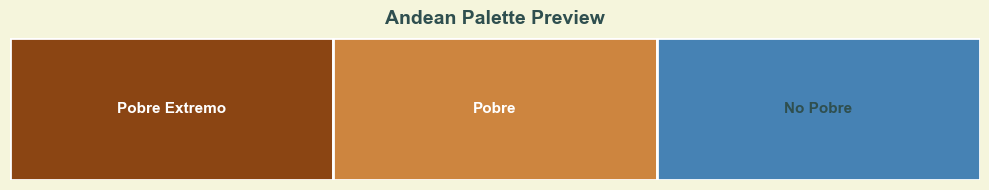

In [17]:
# ==============================================================================
# COLOR SCHEME - ANDEAN PALETTE
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

POVERTY_COLORS = {
    'pobre extremo': '#8B4513',  # Earth brown
    'pobre': '#CD853F',          # Peru tan
    'no pobre': '#4682B4'        # Steel blue (corrected)
}

POVERTY_COLORS_LIST = ['#8B4513', '#CD853F', '#4682B4']
ACCENT = '#DAA520'              # Goldenrod
BACKGROUND = '#F5F5DC'          # Beige
TEXT_COLOR = '#2F4F4F'          # Dark slate gray
GRID_COLOR = '#D3D3D3'          # Light gray

# Set global style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(POVERTY_COLORS_LIST)

print("Color palette configured successfully!")
print("\nPoverty Categories:")
for cat, color in POVERTY_COLORS.items():
    print(f"  {cat.title()}: {color}")

# Create a quick color swatch preview
fig, ax = plt.subplots(1, 1, figsize=(10, 2), facecolor=BACKGROUND)
for i, (cat, color) in enumerate(POVERTY_COLORS.items()):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='white', linewidth=2))
    # Use white text for dark colors, dark text for light colors
    text_color = 'white' if i < 2 else TEXT_COLOR
    ax.text(i + 0.5, 0.5, cat.title(), ha='center', va='center',
            fontweight='bold', fontsize=11, color=text_color)
ax.set_xlim(0, len(POVERTY_COLORS))
ax.set_ylim(0, 1)
ax.axis('off')
ax.set_title('Andean Palette Preview', fontsize=14, fontweight='bold', pad=10, color=TEXT_COLOR)
plt.tight_layout()
plt.show()

In [27]:
# ==============================================================================
# ENHANCED MEDIUM VISUALIZATIONS - PERU POVERTY ANALYSIS
# Production-ready code with improved design and statistical rigor
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURATION & STYLING
# ==============================================================================

class VisualConfig:
    """Centralized configuration for consistent styling"""

    # Color palette
    COLORS = {
        'no pobre': '#4682B4',
        'pobre no extremo': '#CD853F',
        'pobre extremo': '#8B4513',
        'accent': '#DAA520',
        'background': '#F5F5DC',
        'text': '#2F4F4F',
        'grid': '#CCCCCC'
    }

    POVERTY_ORDER = ['no pobre', 'pobre no extremo', 'pobre extremo']

    # Typography
    FONT_SIZES = {
        'hero': 180,
        'title': 22,
        'subtitle': 16,
        'label': 14,
        'annotation': 12,
        'caption': 10
    }

    # Figure settings
    DPI = 300
    FIGURE_FORMATS = ['png', 'svg']  # SVG for Medium's zoom feature

    @classmethod
    def setup_matplotlib(cls):
        """Configure matplotlib defaults"""
        plt.rcParams.update({
            'font.family': 'sans-serif',
            'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
            'axes.unicode_minus': False,
            'figure.dpi': 100,
            'savefig.dpi': cls.DPI,
            'savefig.bbox': 'tight',
            'axes.labelsize': cls.FONT_SIZES['label'],
            'axes.titlesize': cls.FONT_SIZES['title'],
            'xtick.labelsize': cls.FONT_SIZES['caption'],
            'ytick.labelsize': cls.FONT_SIZES['caption']
        })

# Initialize styling
VisualConfig.setup_matplotlib()

# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def validate_data(df: pd.DataFrame, required_cols: List[str]) -> None:
    """Validate dataframe has required columns"""
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

def format_number(num: float, decimals: int = 1) -> str:
    """Format numbers for Spanish locale"""
    return f"{num:,.{decimals}f}".replace(',', 'X').replace('.', ',').replace('X', '.')

def add_watermark(ax, text: str = 'Fuente: ENAHO 2024'):
    """Add consistent watermark to all figures"""
    ax.text(0.98, 0.02, text, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=VisualConfig.FONT_SIZES['caption'],
            color=VisualConfig.COLORS['text'], alpha=0.5, style='italic')

def save_figure(fig, filename: str, output_dir: str = 'output'):
    """Save figure in multiple formats optimized for Medium"""
    Path(output_dir).mkdir(exist_ok=True)

    for fmt in VisualConfig.FIGURE_FORMATS:
        filepath = Path(output_dir) / f"{filename}.{fmt}"
        fig.savefig(filepath, dpi=VisualConfig.DPI,
                   bbox_inches='tight', facecolor=VisualConfig.COLORS['background'],
                   transparent=False)
        print(f"   ✓ Saved: {filepath}")

# ==============================================================================
# VISUALIZATION 1: HERO NUMBER
# ==============================================================================

def create_hero_number(df: pd.DataFrame) -> plt.Figure:
    """
    Opening impact visualization with key statistic

    Design considerations:
    - Large, bold number for immediate impact
    - Context in two levels (description + scale)
    - Minimal distractions
    """
    validate_data(df, ['pobreza', 'factor07'])

    fig, ax = plt.subplots(figsize=(14, 8), facecolor=VisualConfig.COLORS['background'])
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Calculate weighted statistics
    poverty_counts = df.groupby('pobreza')['factor07'].sum()
    total = poverty_counts.sum()
    poor = poverty_counts.get('pobre extremo', 0) + poverty_counts.get('pobre no extremo', 0)
    poverty_rate = (poor / total * 100)

    # Main number - positioned higher for visual balance
    ax.text(0.5, 0.62, f'{poverty_rate:.1f}%',
            ha='center', va='center',
            fontsize=VisualConfig.FONT_SIZES['hero'],
            fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'])

    # Primary message
    ax.text(0.5, 0.38, 'de los hogares peruanos\nviven en situación de pobreza',
            ha='center', va='center',
            fontsize=28, color=VisualConfig.COLORS['text'],
            style='italic', linespacing=1.6)

    # Scale context - converted to millions
    n_households = poor / 1e6
    ax.text(0.5, 0.20, f'Esto representa aproximadamente {n_households:.2f} millones de familias',
            ha='center', va='center',
            fontsize=18, color=VisualConfig.COLORS['text'],
            alpha=0.7, style='italic')

    # Additional context - year reference
    ax.text(0.5, 0.08, 'Datos ENAHO 2024 | Proyecciones poblacionales INEI',
            ha='center', va='center',
            fontsize=14, color=VisualConfig.COLORS['text'], alpha=0.6)

    add_watermark(ax)
    plt.tight_layout()

    return fig

# ==============================================================================
# VISUALIZATION 2: REGIONAL COMPARISON
# ==============================================================================

def create_regional_bars(df: pd.DataFrame) -> plt.Figure:
    """
    Horizontal bar chart showing regional disparities

    Improvements:
    - Color coding by severity threshold
    - Annotations with actual gap context
    - Better label formatting
    """
    validate_data(df, ['dominio', 'pobreza', 'factor07'])

    fig, ax = plt.subplots(figsize=(14, 10), facecolor=VisualConfig.COLORS['background'])

    # Calculate regional poverty rates
    regional_poverty = df.groupby(['dominio', 'pobreza'])['factor07'].sum().unstack(fill_value=0)
    regional_pct = regional_poverty.div(regional_poverty.sum(axis=1), axis=0) * 100

    # Sum poverty categories
    regional_pct['total_poverty'] = (
        regional_pct.get('pobre extremo', 0) +
        regional_pct.get('pobre no extremo', 0)
    )

    regional_pct = regional_pct.sort_values('total_poverty', ascending=True)

    # Create bars with gradient coloring
    y_pos = np.arange(len(regional_pct))

    # Define color thresholds
    def get_bar_color(value):
        if value < 15:
            return VisualConfig.COLORS['no pobre']
        elif value < 30:
            return VisualConfig.COLORS['pobre no extremo']
        else:
            return VisualConfig.COLORS['pobre extremo']

    colors = [get_bar_color(val) for val in regional_pct['total_poverty']]

    bars = ax.barh(y_pos, regional_pct['total_poverty'],
                   color=colors, edgecolor='white',
                   linewidth=2, height=0.7, alpha=0.85)

    # Add value labels with better positioning
    for i, (idx, row) in enumerate(regional_pct.iterrows()):
        val = row['total_poverty']
        ax.text(val + 1.5, i, f'{val:.1f}%',
                va='center', ha='left',
                fontsize=13, fontweight='bold',
                color=VisualConfig.COLORS['text'])

    # Format y-axis labels
    clean_labels = [name.replace('resto costa', 'Resto Costa')
                         .replace('costa', 'Costa')
                         .replace('sierra', 'Sierra')
                         .replace('selva', 'Selva')
                         .title()
                    for name in regional_pct.index]

    ax.set_yticks(y_pos)
    ax.set_yticklabels(clean_labels, fontsize=13, fontweight='500')
    ax.set_xlabel('Tasa de Pobreza (%)', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('Las Brechas Regionales Son Dramáticas\n',
                 fontsize=22, fontweight='bold',
                 color=VisualConfig.COLORS['text'], pad=20)

    # Clean styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_xlim(0, max(regional_pct['total_poverty']) + 10)

    # Context annotation with gap ratio
    max_region = regional_pct.index[-1].title()
    min_region = regional_pct.index[0].title()
    max_val = regional_pct['total_poverty'].iloc[-1]
    min_val = regional_pct['total_poverty'].iloc[0]
    ratio = max_val / min_val if min_val > 0 else 0

    context_text = (f'{max_region}: {max_val:.1f}% | {min_region}: {min_val:.1f}%\n'
                   f'Brecha: {ratio:.1f}x')

    ax.text(0.98, 0.02, context_text,
            transform=ax.transAxes, ha='right', va='bottom',
            fontsize=12, style='italic',
            color=VisualConfig.COLORS['text'], alpha=0.7,
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                     alpha=0.8, edgecolor=VisualConfig.COLORS['accent']))

    plt.tight_layout()
    return fig

# ==============================================================================
# VISUALIZATION 3: INCOME GAP
# ==============================================================================

def create_income_gap(df: pd.DataFrame) -> plt.Figure:
    """
    Income disparity visualization with statistical context

    Enhancements:
    - Show median + IQR for context
    - Better ratio callout
    - Cleaner number formatting
    """
    validate_data(df, ['pobreza', 'inghog2d', 'factor07'])

    fig, ax = plt.subplots(figsize=(14, 9), facecolor=VisualConfig.COLORS['background'])

    # Calculate statistics for each poverty level
    stats = []
    for cat in reversed(VisualConfig.POVERTY_ORDER):
        data = df[df['pobreza'] == cat]['inghog2d']
        stats.append({
            'category': cat.title(),
            'median': data.median(),
            'q25': data.quantile(0.25),
            'q75': data.quantile(0.75),
            'color': VisualConfig.COLORS[cat]
        })

    stats_df = pd.DataFrame(stats)

    # Create main bars
    y_pos = np.arange(len(stats_df))
    bars = ax.barh(y_pos, stats_df['median'],
                   color=stats_df['color'],
                   edgecolor='white', linewidth=3,
                   height=0.65, alpha=0.9)

    # Add median value labels
    for i, row in stats_df.iterrows():
        val = row['median']
        formatted = format_number(val, 0)
        ax.text(val + 500, i, f'S/ {formatted}',
                va='center', ha='left',
                fontsize=15, fontweight='bold',
                color=VisualConfig.COLORS['text'])

    # Add IQR indicators (subtle error bars)
    for i, row in stats_df.iterrows():
        ax.plot([row['q25'], row['q75']], [i, i],
                color='black', linewidth=2, alpha=0.3, zorder=10)
        ax.plot([row['q25'], row['q25']], [i-0.1, i+0.1],
                color='black', linewidth=2, alpha=0.3, zorder=10)
        ax.plot([row['q75'], row['q75']], [i-0.1, i+0.1],
                color='black', linewidth=2, alpha=0.3, zorder=10)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(stats_df['category'], fontsize=15, fontweight='600')
    ax.set_xlabel('Ingreso Mensual Mediano del Hogar (Soles)',
                  fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('La Brecha de Ingresos Es Brutal\n',
                 fontsize=22, fontweight='bold',
                 color=VisualConfig.COLORS['text'], pad=20)

    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.3, linestyle='--', color=VisualConfig.COLORS['grid'])

    # Enhanced context box
    ratio = stats_df['median'].iloc[0] / stats_df['median'].iloc[-1]
    max_income = format_number(stats_df['median'].iloc[0], 0)
    min_income = format_number(stats_df['median'].iloc[-1], 0)

    context = (f'Un hogar no pobre gana S/ {max_income}\n'
              f'vs. S/ {min_income} en pobreza extrema\n\n'
              f'Ratio: {ratio:.1f}x')

    ax.text(0.98, 0.95, context,
            transform=ax.transAxes, ha='right', va='top',
            fontsize=14, fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'],
            linespacing=1.5,
            bbox=dict(boxstyle='round,pad=1', facecolor='white',
                     edgecolor=VisualConfig.COLORS['pobre extremo'],
                     linewidth=3, alpha=0.95))

    # Add legend for IQR
    ax.text(0.02, 0.95, 'Las líneas muestran rango\nintercuartil (25-75%)',
            transform=ax.transAxes, ha='left', va='top',
            fontsize=11, style='italic',
            color=VisualConfig.COLORS['text'], alpha=0.6)

    plt.tight_layout()
    return fig

# ==============================================================================
# VISUALIZATION 4: INCOME DISTRIBUTION
# ==============================================================================

def create_income_distribution(df: pd.DataFrame) -> plt.Figure:
    """
    Overlapping density curves showing income distributions

    Improvements:
    - KDE instead of histogram for smoother curves
    - Better handling of outliers
    - Statistical annotations
    """
    validate_data(df, ['pobreza', 'inghog2d'])

    fig, ax = plt.subplots(figsize=(14, 8), facecolor=VisualConfig.COLORS['background'])

    # Plot KDE for each category
    for cat in VisualConfig.POVERTY_ORDER:
        data = df[df['pobreza'] == cat]['inghog2d']
        # Remove extreme outliers for better visualization
        data_clean = data[(data > 0) & (data < data.quantile(0.98))]

        # Create KDE plot
        data_clean.plot.kde(ax=ax, label=cat.title(),
                           color=VisualConfig.COLORS[cat],
                           linewidth=3, alpha=0.7)

        # Add median line
        median_val = data_clean.median()
        ymax = 0.00003  # Approximate for annotation
        ax.vlines(median_val, 0, ymax,
                 color=VisualConfig.COLORS[cat],
                 linestyle='--', linewidth=2, alpha=0.5)

    ax.set_xlabel('Ingreso Mensual del Hogar (Soles)',
                  fontsize=14, fontweight='bold', labelpad=15)
    ax.set_ylabel('Densidad de Probabilidad',
                  fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('Tres Perús en Uno: Distribuciones de Ingreso Que No Se Tocan\n',
                 fontsize=22, fontweight='bold',
                 color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=13, loc='upper right', framealpha=0.95,
             title='Condición de Pobreza', title_fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(alpha=0.3, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_xlim(0, 120000)

    # Insight box
    ax.text(0.02, 0.95,
            'Las distribuciones tienen\nmínima superposición:\ntres realidades económicas\ncompletamente distintas',
            transform=ax.transAxes, ha='left', va='top',
            fontsize=13, style='italic',
            color=VisualConfig.COLORS['text'],
            linespacing=1.5,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['accent'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# VISUALIZATION 5: WATER ACCESS
# ==============================================================================

def create_water_access(df: pd.DataFrame) -> plt.Figure:
    """
    Stacked bar showing water access inequality

    Enhancements:
    - Cleaner category definitions
    - Better percentage labels
    - Impact framing
    """
    validate_data(df, ['pobreza', 'p110', 'factor07'])

    fig, ax = plt.subplots(figsize=(14, 8), facecolor=VisualConfig.COLORS['background'])

    # Create binary water access variable
    df_temp = df.copy()
    df_temp['agua_red'] = df_temp['p110'].apply(
        lambda x: 'Red pública\nen vivienda' if 'red publica, dentro' in str(x).lower()
        else 'Sin acceso\na red pública'
    )

    # Calculate weighted percentages
    water_data = df_temp.groupby(['pobreza', 'agua_red'])['factor07'].sum().unstack(fill_value=0)
    water_pct = water_data.div(water_data.sum(axis=1), axis=0) * 100
    water_pct = water_pct.reindex(VisualConfig.POVERTY_ORDER)

    # Plot stacked bars
    x = np.arange(len(water_pct))
    width = 0.6

    p1 = ax.bar(x, water_pct['Red pública\nen vivienda'], width,
                label='Red pública en vivienda',
                color=VisualConfig.COLORS['no pobre'],
                edgecolor='white', linewidth=2.5)

    p2 = ax.bar(x, water_pct['Sin acceso\na red pública'], width,
                bottom=water_pct['Red pública\nen vivienda'],
                label='Sin acceso a red pública',
                color=VisualConfig.COLORS['pobre extremo'],
                edgecolor='white', linewidth=2.5)

    # Add percentage labels (only if > 8% for readability)
    for i, cat in enumerate(VisualConfig.POVERTY_ORDER):
        val_access = water_pct.loc[cat, 'Red pública\nen vivienda']
        val_no_access = water_pct.loc[cat, 'Sin acceso\na red pública']

        if val_access > 8:
            ax.text(i, val_access/2, f'{val_access:.1f}%',
                   ha='center', va='center',
                   fontsize=14, fontweight='bold', color='white')

        if val_no_access > 8:
            ax.text(i, val_access + val_no_access/2, f'{val_no_access:.1f}%',
                   ha='center', va='center',
                   fontsize=14, fontweight='bold', color='white')

    # Format x-axis
    labels = [cat.replace(' ', '\n').title() for cat in VisualConfig.POVERTY_ORDER]
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=13, fontweight='600')
    ax.set_ylabel('Porcentaje de Hogares (%)',
                  fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('El Acceso a Agua Potable: Un Privilegio, No un Derecho Universal\n',
                 fontsize=22, fontweight='bold',
                 color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=12, loc='upper right', framealpha=0.95)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_ylim(0, 105)

    # Impact context
    no_access_extreme = water_pct.loc['pobre extremo', 'Sin acceso\na red pública']
    n_households = df[df['pobreza'] == 'pobre extremo']['factor07'].sum() * (no_access_extreme/100) / 1e6

    context = (f'{no_access_extreme:.0f}% de hogares en\npobreza extrema carecen\nde agua potable en casa\n\n'
              f'≈ {n_households:.2f} millones de familias')

    ax.text(0.02, 0.95, context,
            transform=ax.transAxes, ha='left', va='top',
            fontsize=13, fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'],
            linespacing=1.5,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['pobre extremo'],
                     linewidth=2.5))

    plt.tight_layout()
    return fig

# ==============================================================================
# VISUALIZATION 6: BASIC NEEDS INDEX
# ==============================================================================

def create_nbi_comparison(df: pd.DataFrame) -> plt.Figure:
    """
    Grouped bars comparing multiple deprivation indicators

    Improvements:
    - Better indicator labeling
    - Statistical significance indicators
    - More compact layout
    """
    validate_data(df, ['pobreza', 'factor07', 'nbi1', 'nbi2', 'nbi3', 'nbi4', 'nbi5'])

    fig, ax = plt.subplots(figsize=(14, 10), facecolor=VisualConfig.COLORS['background'])

    # Define indicators with cleaner labels
    nbi_indicators = {
        'nbi1': ('Vivienda\nInadecuada', 'inadecuada'),
        'nbi2': ('Hacinamiento', 'con hacinamiento'),
        'nbi3': ('Sin Servicios\nHigiénicos', 'sin servicios'),
        'nbi4': ('Niños sin\nEscuela', 'no asisten'),
        'nbi5': ('Alta Dependencia\nEconómica', 'con alta')
    }

    # Calculate percentages
    nbi_results = []
    for nbi_var, (label, keyword) in nbi_indicators.items():
        row_data = {'Indicador': label}
        for cat in VisualConfig.POVERTY_ORDER:
            mask = (df['pobreza'] == cat) & (df[nbi_var].str.contains(keyword, case=False, na=False))
            affected = df[mask]['factor07'].sum()
            total = df[df['pobreza'] == cat]['factor07'].sum()
            pct = (affected / total * 100) if total > 0 else 0
            row_data[cat] = pct
        nbi_results.append(row_data)

    nbi_df = pd.DataFrame(nbi_results).set_index('Indicador')
    nbi_df = nbi_df[VisualConfig.POVERTY_ORDER]

    # Create grouped bars
    x = np.arange(len(nbi_df))
    width = 0.26

    for i, cat in enumerate(VisualConfig.POVERTY_ORDER):
        offset = (i - 1) * width
        bars = ax.bar(x + offset, nbi_df[cat], width,
                      label=cat.title(),
                      color=VisualConfig.COLORS[cat],
                      edgecolor='white', linewidth=1.5, alpha=0.9)

        # Add value labels (only if > 5% to avoid clutter)
        for j, bar in enumerate(bars):
            height = bar.get_height()
            if height > 5:
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                       f'{height:.0f}%',
                       ha='center', va='bottom',
                       fontsize=10, fontweight='bold',
                       color=VisualConfig.COLORS['text'])

    ax.set_xticks(x)
    ax.set_xticklabels(nbi_df.index, fontsize=12, fontweight='600')
    ax.set_ylabel('Hogares Afectados (%)',
                  fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('Necesidades Básicas Insatisfechas: El Panorama Completo\n',
                 fontsize=22, fontweight='bold',
                 color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=12, loc='upper left', framealpha=0.95, ncol=3,
             title='Condición de Pobreza', title_fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.3, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_ylim(0, nbi_df.max().max() + 10)

    # Add context about compound deprivation
    avg_extreme = nbi_df['pobre extremo'].mean()
    avg_no_pobre = nbi_df['no pobre'].mean()

    context = (f'En promedio, {avg_extreme:.0f}% de hogares\n'
              f'en pobreza extrema sufren cada\ncarencia vs. {avg_no_pobre:.0f}% de no pobres')

    ax.text(0.98, 0.98, context,
            transform=ax.transAxes, ha='right', va='top',
            fontsize=12, style='italic',
            color=VisualConfig.COLORS['text'],
            linespacing=1.5,
            bbox=dict(boxstyle='round,pad=0.6', facecolor='white',
                     alpha=0.9, edgecolor=VisualConfig.COLORS['accent']))

    plt.tight_layout()
    return fig

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def generate_all_visualizations(df: pd.DataFrame, output_dir: str = 'medium_visuals'):
    """Generate all visualizations for Medium post"""

    print("\n" + "="*80)
    print("🎨 GENERATING ENHANCED MEDIUM VISUALIZATIONS")
    print("="*80 + "\n")

    visualizations = [
        ("01_hero", create_hero_number, "Hero number - Opening impact"),
        ("02_regional", create_regional_bars, "Regional inequality map"),
        ("03_income_gap", create_income_gap, "Income disparity comparison"),
        ("04_distribution", create_income_distribution, "Income distribution curves"),
        ("05_water", create_water_access, "Water access inequality"),
        ("06_nbi", create_nbi_comparison, "Basic needs index comparison")
    ]

    for filename, func, description in visualizations:
        print(f"📊 Creating: {description}...")
        try:
            fig = func(df)
            save_figure(fig, f"medium_{filename}", output_dir)
            plt.close(fig)
            print(f"   ✓ Success\n")
        except Exception as e:
            print(f"   ✗ Error: {e}\n")
            continue

    print("="*80)
    print("✅ GENERATION COMPLETE")
    print(f"📁 Files saved to: {output_dir}/")
    print("="*80)

    print_medium_guide()

def print_medium_guide():
    """Print guide for using visualizations in Medium"""
    print("\n" + "="*80)
    print("📖 MEDIUM PUBLISHING GUIDE")
    print("="*80 + "\n")

    print("""
🎯 RECOMMENDED ARTICLE STRUCTURE:

1. medium_01_hero.png [OPENING]
   "Un número que no podemos ignorar..."
   → Lead with impact, establish urgency

2. medium_02_regional.png [CONTEXT]
   "Pero la pobreza no es uniforme..."
   → Show geographic disparities

3. medium_03_income_gap.png [EVIDENCE]
   "Detrás de las cifras hay una realidad brutal..."
   → Quantify economic inequality

4. medium_04_distribution.png [DEPTH]
   "No son diferencias graduales, son mundos paralelos..."
   → Visualize the disconnect

5. medium_05_water.png [HUMAN IMPACT]
   "La pobreza no es abstracta - afecta lo más básico..."
   → Connect to daily life

6. medium_06_nbi.png [SYNTHESIS]
   "El panorama completo nos muestra la magnitud del desafío..."
   → Bring it all together

💡 MEDIUM-SPECIFIC TIPS:

✓ Use SVG files - they support Medium's zoom feature
✓ Add alt-text to each image for accessibility
✓ Place captions that complement (not repeat) the chart text
✓ Consider mobile readers - test how charts look on small screens
✓ Link to data sources in your Medium post
✓ Include a "Methodology" section at the end

📊 FIGURE SPECIFICATIONS:

- Resolution: 300 DPI (publication quality)
- Formats: PNG (for preview) + SVG (for Medium upload)
- Dimensions: 14x8 to 14x10 inches (optimized for Medium's layout)
- Color: Consistent Andean palette throughout

🔗 NEXT STEPS:

1. Review each visualization for accuracy
2. Prepare narrative text for each transition
3. Add data disclaimers where appropriate
4. Test readability on mobile device
5. Get peer review before publishing

""")
    print("="*80 + "\n")

# ==============================================================================
# EXAMPLE USAGE
# ==============================================================================

if __name__ == "__main__":
    # Assuming 'df' is already loaded from ENAHO data
    # df = pd.read_csv('enaho_data.csv')

    # Generate all visualizations
    # generate_all_visualizations(df)

    print("Code ready! Load your dataframe and run:")
    print(">>> generate_all_visualizations(df)")

Code ready! Load your dataframe and run:
>>> generate_all_visualizations(df)


In [26]:
generate_all_visualizations(data_final)


🎨 GENERATING ENHANCED MEDIUM VISUALIZATIONS

📊 Creating: Hero number - Opening impact...
   ✓ Saved: medium_visuals\medium_01_hero.png
   ✓ Saved: medium_visuals\medium_01_hero.svg
   ✓ Success

📊 Creating: Regional inequality map...
   ✓ Saved: medium_visuals\medium_02_regional.png
   ✓ Saved: medium_visuals\medium_02_regional.svg
   ✓ Success

📊 Creating: Income disparity comparison...
   ✓ Saved: medium_visuals\medium_03_income_gap.png
   ✓ Saved: medium_visuals\medium_03_income_gap.svg
   ✓ Success

📊 Creating: Income distribution curves...
   ✓ Saved: medium_visuals\medium_04_distribution.png
   ✓ Saved: medium_visuals\medium_04_distribution.svg
   ✓ Success

📊 Creating: Water access inequality...
   ✓ Saved: medium_visuals\medium_05_water.png
   ✓ Saved: medium_visuals\medium_05_water.svg
   ✓ Success

📊 Creating: Basic needs index comparison...
   ✓ Saved: medium_visuals\medium_06_nbi.png
   ✓ Saved: medium_visuals\medium_06_nbi.svg
   ✓ Success

✅ GENERATION COMPLETE
📁 Files s

In [28]:
# ==============================================================================
# ADVANCED POVERTY VISUALIZATIONS - ENAHO 2024
# Gráficos adicionales para análisis profundo
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# CONFIGURATION (Same as before)
# ==============================================================================

class VisualConfig:
    COLORS = {
        'no pobre': '#4682B4',
        'pobre no extremo': '#CD853F',
        'pobre extremo': '#8B4513',
        'accent': '#DAA520',
        'background': '#F5F5DC',
        'text': '#2F4F4F',
        'grid': '#CCCCCC'
    }
    POVERTY_ORDER = ['no pobre', 'pobre no extremo', 'pobre extremo']
    FONT_SIZES = {
        'hero': 180, 'title': 22, 'subtitle': 16, 'label': 14,
        'value': 13, 'annotation': 12, 'caption': 10
    }
    DPI = 300

    @classmethod
    def setup_matplotlib(cls):
        plt.rcParams.update({
            'font.family': 'sans-serif',
            'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
            'axes.unicode_minus': False,
            'figure.dpi': 100,
            'savefig.dpi': cls.DPI,
            'savefig.bbox': 'tight',
        })

VisualConfig.setup_matplotlib()

def format_number(num: float, decimals: int = 1) -> str:
    return f"{num:,.{decimals}f}".replace(',', 'X').replace('.', ',').replace('X', '.')

def save_figure(fig, filename: str, output_dir: str = 'medium_visuals'):
    Path(output_dir).mkdir(exist_ok=True)
    for fmt in ['png', 'svg']:
        filepath = Path(output_dir) / f"{filename}.{fmt}"
        fig.savefig(filepath, dpi=VisualConfig.DPI, bbox_inches='tight',
                   facecolor=VisualConfig.COLORS['background'])
    print(f"   ✓ {filename}.png/svg")

# ==============================================================================
# GRÁFICO 7: COMPOSICIÓN DE POBREZA POR REGIÓN (STACKED BARS)
# ==============================================================================

def create_poverty_composition_regional(df: pd.DataFrame) -> plt.Figure:
    """
    Muestra composición de pobreza extrema vs no extrema por región
    INSIGHT: Algunas regiones tienen más pobreza extrema que otras
    """

    fig, ax = plt.subplots(figsize=(14, 10), facecolor=VisualConfig.COLORS['background'])

    # Calculate composition by region
    regional = df.groupby(['dominio', 'pobreza'])['factor07'].sum().unstack(fill_value=0)
    regional_pct = regional.div(regional.sum(axis=1), axis=0) * 100
    regional_pct = regional_pct.sort_values('pobre extremo', ascending=True)

    # Create stacked horizontal bars
    y_pos = np.arange(len(regional_pct))
    width = 0.7

    # Plot each poverty category
    left = np.zeros(len(regional_pct))

    for cat in ['pobre extremo', 'pobre no extremo', 'no pobre']:
        if cat not in regional_pct.columns:
            continue
        values = regional_pct[cat]
        bars = ax.barh(y_pos, values, width, left=left,
                       label=cat.title(),
                       color=VisualConfig.COLORS[cat],
                       edgecolor='white', linewidth=2)

        # Add percentages (only if >5%)
        for i, (val, l) in enumerate(zip(values, left)):
            if val > 5:
                ax.text(l + val/2, i, f'{val:.1f}%',
                       ha='center', va='center',
                       fontsize=11, fontweight='bold', color='white')

        left += values

    # Format labels
    clean_labels = [name.replace('resto costa', 'Resto Costa')
                         .replace('costa', 'Costa')
                         .replace('sierra', 'Sierra')
                         .replace('selva', 'Selva')
                         .replace('lima metropolitana', 'Lima Metropolitana')
                         .title()
                    for name in regional_pct.index]

    ax.set_yticks(y_pos)
    ax.set_yticklabels(clean_labels, fontsize=13, fontweight='500')
    ax.set_xlabel('Composición de Hogares (%)', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('La Composición de la Pobreza Varía por Región\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=12, loc='lower right', framealpha=0.95, ncol=3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.25, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_xlim(0, 100)

    # Context
    highest_extreme = regional_pct['pobre extremo'].idxmax()
    highest_val = regional_pct.loc[highest_extreme, 'pobre extremo']

    context = (f'Región con más\npobreza extrema:\n\n'
              f'{highest_extreme.title()}\n{highest_val:.1f}%')

    ax.text(0.02, 0.98, context, transform=ax.transAxes,
            ha='left', va='top', fontsize=11, fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'],
            linespacing=1.4,
            bbox=dict(boxstyle='round,pad=0.7', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['pobre extremo'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# GRÁFICO 8: URBANO VS RURAL (COMPARACIÓN CLARA)
# ==============================================================================

def create_urban_rural_comparison(df: pd.DataFrame) -> plt.Figure:
    """
    Compara pobreza urbana vs rural usando estrato
    INSIGHT: La ruralidad es un predictor clave de pobreza
    """

    fig, ax = plt.subplots(figsize=(14, 8), facecolor=VisualConfig.COLORS['background'])

    # Classify urban/rural based on estrato
    df_temp = df.copy()
    df_temp['area'] = df_temp['estrato'].apply(
        lambda x: 'Rural' if 'rural' in str(x).lower() else 'Urbano'
    )

    # Calculate poverty rates by area
    area_poverty = df_temp.groupby(['area', 'pobreza'])['factor07'].sum().unstack(fill_value=0)
    area_pct = area_poverty.div(area_poverty.sum(axis=1), axis=0) * 100

    # Create grouped bars
    x = np.arange(len(area_pct))
    width = 0.25

    for i, cat in enumerate(VisualConfig.POVERTY_ORDER):
        if cat not in area_pct.columns:
            continue
        offset = (i - 1) * width
        bars = ax.bar(x + offset, area_pct[cat], width,
                      label=cat.title(),
                      color=VisualConfig.COLORS[cat],
                      edgecolor='white', linewidth=2)

        # Add percentages
        for bar in bars:
            height = bar.get_height()
            if height > 2:
                ax.text(bar.get_x() + bar.get_width()/2, height/2,
                       f'{height:.1f}%',
                       ha='center', va='center',
                       fontsize=12, fontweight='bold', color='white')

    ax.set_xticks(x)
    ax.set_xticklabels(area_pct.index, fontsize=15, fontweight='bold')
    ax.set_ylabel('Porcentaje de Hogares', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('La Brecha Urbano-Rural Define la Pobreza en el Perú\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=12, loc='upper left', framealpha=0.95)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_ylim(0, max(area_pct.max()) + 10)

    # Calculate gap
    rural_poverty = area_pct.loc['Rural', 'pobre extremo'] + area_pct.loc['Rural', 'pobre no extremo']
    urban_poverty = area_pct.loc['Urbano', 'pobre extremo'] + area_pct.loc['Urbano', 'pobre no extremo']
    gap = rural_poverty / urban_poverty if urban_poverty > 0 else 0

    context = (f'Pobreza Rural: {rural_poverty:.1f}%\n'
              f'Pobreza Urbana: {urban_poverty:.1f}%\n\n'
              f'La zona rural tiene\n{gap:.1f}x más pobreza')

    ax.text(0.98, 0.98, context, transform=ax.transAxes,
            ha='right', va='top', fontsize=12, fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'],
            linespacing=1.4,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['accent'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# GRÁFICO 9: TAMAÑO DEL HOGAR VS POBREZA
# ==============================================================================

def create_household_size_poverty(df: pd.DataFrame) -> plt.Figure:
    """
    Muestra cómo el tamaño del hogar se relaciona con pobreza
    INSIGHT: Hogares grandes = más pobreza
    """

    fig, ax = plt.subplots(figsize=(14, 8), facecolor=VisualConfig.COLORS['background'])

    # Calculate average household size by poverty status
    size_by_poverty = df.groupby('pobreza')['mieperho'].mean().reindex(VisualConfig.POVERTY_ORDER)

    # Also show distribution
    size_poverty_dist = df.groupby(['pobreza', 'mieperho'])['factor07'].sum().unstack(fill_value=0)
    size_poverty_pct = size_poverty_dist.div(size_poverty_dist.sum(axis=1), axis=0) * 100

    # Create bars for average size
    y_pos = np.arange(len(size_by_poverty))
    bars = ax.barh(y_pos, size_by_poverty,
                   color=[VisualConfig.COLORS[cat] for cat in VisualConfig.POVERTY_ORDER],
                   edgecolor='white', linewidth=3, height=0.6, alpha=0.9)

    # Add values
    for i, (cat, val) in enumerate(size_by_poverty.items()):
        ax.text(val + 0.05, i, f'{val:.1f} miembros',
               va='center', ha='left',
               fontsize=14, fontweight='bold',
               color=VisualConfig.COLORS['text'])

    ax.set_yticks(y_pos)
    ax.set_yticklabels([cat.title() for cat in size_by_poverty.index],
                       fontsize=15, fontweight='600')
    ax.set_xlabel('Promedio de Miembros por Hogar', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('Más Miembros, Más Pobreza: El Círculo Vicioso\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'], pad=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.25, linestyle='--', color=VisualConfig.COLORS['grid'])

    # Context
    max_size = size_by_poverty.max()
    min_size = size_by_poverty.min()
    diff = max_size - min_size

    context = (f'Los hogares en pobreza\nextrema tienen en promedio\n'
              f'{diff:.1f} miembros más\nque los no pobres\n\n'
              f'Más bocas que alimentar\ncon menos recursos')

    ax.text(0.98, 0.98, context, transform=ax.transAxes,
            ha='right', va='top', fontsize=11, fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'],
            linespacing=1.4,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['pobre extremo'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# GRÁFICO 10: MÚLTIPLES PRIVACIONES (NBI COMPUESTOS)
# ==============================================================================

def create_multiple_deprivations(df: pd.DataFrame) -> plt.Figure:
    """
    Muestra hogares con múltiples NBIs simultáneos
    INSIGHT: La pobreza es acumulativa
    """

    fig, ax = plt.subplots(figsize=(14, 9), facecolor=VisualConfig.COLORS['background'])

    # Count how many NBIs each household has
    df_temp = df.copy()
    nbi_cols = {
        'nbi1': 'inadecuada',
        'nbi2': 'con hacinamiento',
        'nbi3': 'sin servicios',
        'nbi4': 'no asisten',
        'nbi5': 'con alta'
    }

    df_temp['nbi_count'] = 0
    for col, keyword in nbi_cols.items():
        df_temp['nbi_count'] += df_temp[col].str.contains(keyword, case=False, na=False).astype(int)

    # Calculate distribution by poverty status
    nbi_dist = df_temp.groupby(['pobreza', 'nbi_count'])['factor07'].sum().unstack(fill_value=0)
    nbi_pct = nbi_dist.div(nbi_dist.sum(axis=1), axis=0) * 100
    nbi_pct = nbi_pct.reindex(VisualConfig.POVERTY_ORDER)

    # Create stacked bars
    x = np.arange(len(nbi_pct))
    width = 0.6
    bottom = np.zeros(len(nbi_pct))

    # Color gradient for number of NBIs
    colors_gradient = ['#2E8B57', '#FFD700', '#FF8C00', '#FF4500', '#8B0000', '#4B0000']

    for nbi_num in range(6):
        if nbi_num not in nbi_pct.columns:
            continue
        values = nbi_pct[nbi_num]
        bars = ax.bar(x, values, width, bottom=bottom,
                     label=f'{nbi_num} carencias' if nbi_num > 0 else 'Sin carencias',
                     color=colors_gradient[nbi_num],
                     edgecolor='white', linewidth=1.5)

        # Add percentages (only if >5%)
        for i, val in enumerate(values):
            if val > 5:
                ax.text(i, bottom[i] + val/2, f'{val:.0f}%',
                       ha='center', va='center',
                       fontsize=10, fontweight='bold', color='white')

        bottom += values

    ax.set_xticks(x)
    ax.set_xticklabels([cat.replace(' ', '\n').title() for cat in nbi_pct.index],
                       fontsize=13, fontweight='600')
    ax.set_ylabel('Porcentaje de Hogares', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('La Pobreza Es Acumulativa: Múltiples Privaciones Simultáneas\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=10, loc='upper left', framealpha=0.95, ncol=2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_ylim(0, 105)

    # Calculate severe deprivation (3+ NBIs)
    severe = nbi_pct[[col for col in nbi_pct.columns if col >= 3]].sum(axis=1)

    context = (f'Hogares con 3+ carencias:\n\n'
              f'Pobreza extrema: {severe.get("pobre extremo", 0):.1f}%\n'
              f'Pobreza no extrema: {severe.get("pobre no extremo", 0):.1f}%\n'
              f'No pobres: {severe.get("no pobre", 0):.1f}%\n\n'
              f'Las privaciones se\nacumulan y refuerzan')

    ax.text(0.98, 0.98, context, transform=ax.transAxes,
            ha='right', va='top', fontsize=11,
            color=VisualConfig.COLORS['text'],
            linespacing=1.4,
            bbox=dict(boxstyle='round,pad=0.7', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['accent'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# GRÁFICO 11: CALIDAD DE VIVIENDA (MATERIALES)
# ==============================================================================

def create_housing_quality(df: pd.DataFrame) -> plt.Figure:
    """
    Analiza materiales de construcción por nivel de pobreza
    INSIGHT: Los materiales revelan desigualdad estructural
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8),
                                    facecolor=VisualConfig.COLORS['background'])

    # --- PAREDES (p102) ---
    # Classify materials as adequate/inadequate
    df_temp = df.copy()
    adequate_walls = ['ladrillo', 'cemento', 'concreto', 'cal']
    df_temp['pared_adecuada'] = df_temp['p102'].apply(
        lambda x: 'Adecuada' if any(mat in str(x).lower() for mat in adequate_walls)
        else 'Inadecuada'
    )

    walls = df_temp.groupby(['pobreza', 'pared_adecuada'])['factor07'].sum().unstack(fill_value=0)
    walls_pct = walls.div(walls.sum(axis=1), axis=0) * 100
    walls_pct = walls_pct.reindex(VisualConfig.POVERTY_ORDER)

    # Plot walls
    x = np.arange(len(walls_pct))
    width = 0.6

    p1 = ax1.bar(x, walls_pct.get('Adecuada', 0), width,
                label='Materiales Adecuados',
                color=VisualConfig.COLORS['no pobre'],
                edgecolor='white', linewidth=2)
    p2 = ax1.bar(x, walls_pct.get('Inadecuada', 0), width,
                bottom=walls_pct.get('Adecuada', 0),
                label='Materiales Inadecuados',
                color=VisualConfig.COLORS['pobre extremo'],
                edgecolor='white', linewidth=2)

    # Add percentages
    for i, cat in enumerate(VisualConfig.POVERTY_ORDER):
        val1 = walls_pct.loc[cat, 'Adecuada'] if 'Adecuada' in walls_pct.columns else 0
        val2 = walls_pct.loc[cat, 'Inadecuada'] if 'Inadecuada' in walls_pct.columns else 0

        if val1 > 5:
            ax1.text(i, val1/2, f'{val1:.0f}%',
                    ha='center', va='center',
                    fontsize=12, fontweight='bold', color='white')
        if val2 > 5:
            ax1.text(i, val1 + val2/2, f'{val2:.0f}%',
                    ha='center', va='center',
                    fontsize=12, fontweight='bold', color='white')

    ax1.set_xticks(x)
    ax1.set_xticklabels([cat.replace(' ', '\n').title() for cat in walls_pct.index],
                        fontsize=12, fontweight='600')
    ax1.set_ylabel('Porcentaje de Hogares', fontsize=13, fontweight='bold')
    ax1.set_title('Material de Paredes\n', fontsize=18, fontweight='bold',
                  color=VisualConfig.COLORS['text'])
    ax1.legend(fontsize=10, loc='upper right', framealpha=0.95)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.grid(axis='y', alpha=0.25, linestyle='--')
    ax1.set_ylim(0, 105)

    # --- PISO (p103) ---
    adequate_floor = ['cemento', 'losetas', 'parquet', 'madera pulida', 'vinilico']
    df_temp['piso_adecuado'] = df_temp['p103'].apply(
        lambda x: 'Adecuado' if any(mat in str(x).lower() for mat in adequate_floor)
        else 'Inadecuado'
    )

    floors = df_temp.groupby(['pobreza', 'piso_adecuado'])['factor07'].sum().unstack(fill_value=0)
    floors_pct = floors.div(floors.sum(axis=1), axis=0) * 100
    floors_pct = floors_pct.reindex(VisualConfig.POVERTY_ORDER)

    # Plot floors
    p1 = ax2.bar(x, floors_pct.get('Adecuado', 0), width,
                label='Materiales Adecuados',
                color=VisualConfig.COLORS['no pobre'],
                edgecolor='white', linewidth=2)
    p2 = ax2.bar(x, floors_pct.get('Inadecuado', 0), width,
                bottom=floors_pct.get('Adecuado', 0),
                label='Materiales Inadecuados',
                color=VisualConfig.COLORS['pobre extremo'],
                edgecolor='white', linewidth=2)

    # Add percentages
    for i, cat in enumerate(VisualConfig.POVERTY_ORDER):
        val1 = floors_pct.loc[cat, 'Adecuado'] if 'Adecuado' in floors_pct.columns else 0
        val2 = floors_pct.loc[cat, 'Inadecuado'] if 'Inadecuado' in floors_pct.columns else 0

        if val1 > 5:
            ax2.text(i, val1/2, f'{val1:.0f}%',
                    ha='center', va='center',
                    fontsize=12, fontweight='bold', color='white')
        if val2 > 5:
            ax2.text(i, val1 + val2/2, f'{val2:.0f}%',
                    ha='center', va='center',
                    fontsize=12, fontweight='bold', color='white')

    ax2.set_xticks(x)
    ax2.set_xticklabels([cat.replace(' ', '\n').title() for cat in floors_pct.index],
                        fontsize=12, fontweight='600')
    ax2.set_ylabel('Porcentaje de Hogares', fontsize=13, fontweight='bold')
    ax2.set_title('Material de Pisos\n', fontsize=18, fontweight='bold',
                  color=VisualConfig.COLORS['text'])
    ax2.legend(fontsize=10, loc='upper right', framealpha=0.95)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.grid(axis='y', alpha=0.25, linestyle='--')
    ax2.set_ylim(0, 105)

    fig.suptitle('Calidad de Vivienda: Los Materiales Cuentan Historias\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'],
                 y=0.98)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# ==============================================================================
# GRÁFICO 12: SERVICIOS BÁSICOS COMBINADOS (AGUA + DESAGÜE)
# ==============================================================================

def create_combined_services(df: pd.DataFrame) -> plt.Figure:
    """
    Analiza acceso simultáneo a agua y desagüe
    INSIGHT: Tener solo uno no es suficiente
    """

    fig, ax = plt.subplots(figsize=(14, 9), facecolor=VisualConfig.COLORS['background'])

    # Create combined categories
    df_temp = df.copy()
    df_temp['tiene_agua'] = df_temp['p110'].str.contains('red publica, dentro', case=False, na=False)
    df_temp['tiene_desague'] = df_temp['p111a'].str.contains('red publica de desagüe dentro',
                                                              case=False, na=False)

    def classify_services(row):
        if row['tiene_agua'] and row['tiene_desague']:
            return 'Ambos servicios'
        elif row['tiene_agua']:
            return 'Solo agua'
        elif row['tiene_desague']:
            return 'Solo desagüe'
        else:
            return 'Ninguno'

    df_temp['servicios'] = df_temp.apply(classify_services, axis=1)

    # Calculate distribution
    services = df_temp.groupby(['pobreza', 'servicios'])['factor07'].sum().unstack(fill_value=0)
    services_pct = services.div(services.sum(axis=1), axis=0) * 100
    services_pct = services_pct.reindex(VisualConfig.POVERTY_ORDER)

    # Reorder columns
    service_order = ['Ambos servicios', 'Solo agua', 'Solo desagüe', 'Ninguno']
    services_pct = services_pct[[col for col in service_order if col in services_pct.columns]]

    # Create stacked bars
    x = np.arange(len(services_pct))
    width = 0.6
    bottom = np.zeros(len(services_pct))

    service_colors = {
        'Ambos servicios': VisualConfig.COLORS['no pobre'],
        'Solo agua': '#87CEEB',
        'Solo desagüe': '#DDA0DD',
        'Ninguno': VisualConfig.COLORS['pobre extremo']
    }

    for service in service_order:
        if service not in services_pct.columns:
            continue
        values = services_pct[service]
        bars = ax.bar(x, values, width, bottom=bottom,
                     label=service,
                     color=service_colors[service],
                     edgecolor='white', linewidth=2)

        # Add percentages
        for i, val in enumerate(values):
            if val > 5:
                ax.text(i, bottom[i] + val/2, f'{val:.0f}%',
                       ha='center', va='center',
                       fontsize=11, fontweight='bold', color='white')

        bottom += values

    ax.set_xticks(x)
    ax.set_xticklabels([cat.replace(' ', '\n').title() for cat in services_pct.index],
                       fontsize=13, fontweight='600')
    ax.set_ylabel('Porcentaje de Hogares', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('Acceso a Servicios Básicos: La Historia Completa\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=11, loc='lower left', framealpha=0.95, ncol=2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linestyle='--', color=VisualConfig.COLORS['grid'])
    ax.set_ylim(0, 105)

    # Context
    both = services_pct.get('Ambos servicios', pd.Series([0, 0, 0]))
    extreme_both = both.get('pobre extremo', 0)
    no_pobre_both = both.get('no pobre', 0)

    context = (f'Con ambos servicios:\n\n'
              f'No pobres: {no_pobre_both:.0f}%\n'
              f'Pobreza extrema: {extreme_both:.0f}%\n\n'
              f'Brecha: {no_pobre_both/extreme_both:.1f}x' if extreme_both > 0 else ''
              f'\n\nTener solo uno no\nes suficiente para\nuna vida digna')

    ax.text(0.98, 0.98, context, transform=ax.transAxes,
            ha='right', va='top', fontsize=11, fontweight='bold',
            color=VisualConfig.COLORS['text'],
            linespacing=1.4,
            bbox=dict(boxstyle='round,pad=0.7', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['accent'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# GRÁFICO 13: DESIGUALDAD DE INGRESOS (DECILES)
# ==============================================================================

def create_income_deciles(df: pd.DataFrame) -> plt.Figure:
    """
    Muestra distribución de ingresos por deciles
    INSIGHT: Concentración extrema en el top 10%
    """

    fig, ax = plt.subplots(figsize=(14, 8), facecolor=VisualConfig.COLORS['background'])

    # Calculate income deciles (weighted)
    df_sorted = df.sort_values('inghog2d')
    df_sorted['cumsum_weight'] = df_sorted['factor07'].cumsum()
    total_weight = df_sorted['factor07'].sum()

    decile_bounds = [i/10 for i in range(11)]
    decile_values = []

    for i in range(10):
        lower = decile_bounds[i] * total_weight
        upper = decile_bounds[i+1] * total_weight
        mask = (df_sorted['cumsum_weight'] > lower) & (df_sorted['cumsum_weight'] <= upper)
        decile_avg = (df_sorted[mask]['inghog2d'] * df_sorted[mask]['factor07']).sum() / df_sorted[mask]['factor07'].sum()
        decile_values.append(decile_avg)

    # Plot deciles
    x = np.arange(1, 11)
    colors_gradient = plt.cm.RdYlGn(np.linspace(0.2, 0.8, 10))

    bars = ax.bar(x, decile_values, color=colors_gradient,
                  edgecolor='white', linewidth=2, alpha=0.9)

    # Add values
    for i, (bar, val) in enumerate(zip(bars, decile_values)):
        ax.text(i+1, val + 1000, f'S/ {format_number(val, 0)}',
               ha='center', va='bottom',
               fontsize=10, fontweight='bold',
               color=VisualConfig.COLORS['text'], rotation=45)

    ax.set_xticks(x)
    ax.set_xticklabels([f'D{i}' for i in range(1, 11)], fontsize=12, fontweight='bold')
    ax.set_xlabel('Decil de Ingreso (D1 = 10% más pobre, D10 = 10% más rico)',
                  fontsize=13, fontweight='bold', labelpad=15)
    ax.set_ylabel('Ingreso Promedio Mensual (Soles)', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('La Desigualdad en Números: Distribución por Deciles\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'], pad=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', alpha=0.25, linestyle='--', color=VisualConfig.COLORS['grid'])

    # Context
    ratio_top_bottom = decile_values[-1] / decile_values[0]

    context = (f'Decil 10 vs Decil 1:\n\n'
              f'D10: S/ {format_number(decile_values[-1], 0)}\n'
              f'D1: S/ {format_number(decile_values[0], 0)}\n\n'
              f'El 10% más rico gana\n{ratio_top_bottom:.0f}x más que el\n10% más pobre')

    ax.text(0.02, 0.98, context, transform=ax.transAxes,
            ha='left', va='top', fontsize=11, fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'],
            linespacing=1.4,
            bbox=dict(boxstyle='round,pad=0.8', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['pobre extremo'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# GRÁFICO 14: INGRESO PER CÁPITA
# ==============================================================================

def create_per_capita_income(df: pd.DataFrame) -> plt.Figure:
    """
    Compara ingreso per cápita por nivel de pobreza
    INSIGHT: El ingreso por persona es lo que realmente importa
    """

    fig, ax = plt.subplots(figsize=(14, 8), facecolor=VisualConfig.COLORS['background'])

    # Calculate per capita income
    df_temp = df.copy()
    df_temp['ingreso_per_capita'] = df_temp['inghog2d'] / df_temp['mieperho']

    # Get statistics by poverty level
    stats = []
    for cat in reversed(VisualConfig.POVERTY_ORDER):
        data = df_temp[df_temp['pobreza'] == cat]['ingreso_per_capita']
        stats.append({
            'category': cat.title(),
            'median': data.median(),
            'mean': data.mean(),
            'color': VisualConfig.COLORS[cat]
        })

    stats_df = pd.DataFrame(stats)

    # Create bars
    y_pos = np.arange(len(stats_df))
    width = 0.35

    bars1 = ax.barh(y_pos - width/2, stats_df['median'], width,
                    label='Mediana', color=stats_df['color'], alpha=0.9,
                    edgecolor='white', linewidth=2)
    bars2 = ax.barh(y_pos + width/2, stats_df['mean'], width,
                    label='Promedio', color=stats_df['color'], alpha=0.6,
                    edgecolor='white', linewidth=2)

    # Add values
    for i, row in stats_df.iterrows():
        ax.text(row['median'] + 50, i - width/2, f'S/ {format_number(row["median"], 0)}',
               va='center', ha='left', fontsize=12, fontweight='bold',
               color=VisualConfig.COLORS['text'])
        ax.text(row['mean'] + 50, i + width/2, f'S/ {format_number(row["mean"], 0)}',
               va='center', ha='left', fontsize=11, fontweight='bold',
               color=VisualConfig.COLORS['text'], alpha=0.7)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(stats_df['category'], fontsize=15, fontweight='600')
    ax.set_xlabel('Ingreso Per Cápita Mensual (Soles por persona)',
                  fontsize=14, fontweight='bold', labelpad=15)
    ax.set_title('Ingreso Per Cápita: Lo Que Realmente Llega a Cada Persona\n',
                 fontsize=22, fontweight='bold', color=VisualConfig.COLORS['text'], pad=20)

    ax.legend(fontsize=12, loc='lower right', framealpha=0.95)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(axis='x', alpha=0.25, linestyle='--', color=VisualConfig.COLORS['grid'])

    # Context
    ratio = stats_df['median'].iloc[0] / stats_df['median'].iloc[-1]

    context = (f'Ingreso per cápita\nmediano:\n\n'
              f'No pobre:\nS/ {format_number(stats_df["median"].iloc[0], 0)}\n\n'
              f'Pobreza extrema:\nS/ {format_number(stats_df["median"].iloc[-1], 0)}\n\n'
              f'Brecha: {ratio:.1f}x')

    ax.text(0.02, 0.98, context, transform=ax.transAxes,
            ha='left', va='top', fontsize=11, fontweight='bold',
            color=VisualConfig.COLORS['pobre extremo'],
            linespacing=1.4,
            bbox=dict(boxstyle='round,pad=0.7', facecolor='white',
                     alpha=0.95, edgecolor=VisualConfig.COLORS['pobre extremo'],
                     linewidth=2))

    plt.tight_layout()
    return fig

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

def generate_advanced_visualizations(df: pd.DataFrame, output_dir: str = 'medium_visuals'):
    """Generate all advanced visualizations"""

    print("\n" + "="*80)
    print("🎨 GENERANDO GRÁFICOS AVANZADOS PARA ANÁLISIS PROFUNDO")
    print("="*80 + "\n")

    visualizations = [
        ("07_regional_composition", create_poverty_composition_regional,
         "Composición de pobreza por región"),
        ("08_urban_rural", create_urban_rural_comparison,
         "Comparación urbano-rural"),
        ("09_household_size", create_household_size_poverty,
         "Tamaño del hogar vs pobreza"),
        ("10_multiple_deprivations", create_multiple_deprivations,
         "Privaciones múltiples (NBIs acumulados)"),
        ("11_housing_quality", create_housing_quality,
         "Calidad de vivienda (materiales)"),
        ("12_combined_services", create_combined_services,
         "Servicios básicos combinados"),
        ("13_income_deciles", create_income_deciles,
         "Desigualdad por deciles de ingreso"),
        ("14_per_capita_income", create_per_capita_income,
         "Ingreso per cápita")
    ]

    for filename, func, description in visualizations:
        print(f"📊 Creando: {description}...")
        try:
            fig = func(df)
            save_figure(fig, f"medium_{filename}", output_dir)
            plt.close(fig)
            print(f"   ✅ Completado\n")
        except Exception as e:
            print(f"   ❌ Error: {e}\n")
            import traceback
            traceback.print_exc()
            continue

    print("="*80)
    print("✅ GENERACIÓN COMPLETA - 8 GRÁFICOS ADICIONALES")
    print(f"📁 Total de archivos: {output_dir}/")
    print("="*80)

    print_insights_guide()

def print_insights_guide():
    """Print guide with key insights"""
    print("\n" + "="*80)
    print("💡 INSIGHTS CLAVE DE LOS NUEVOS GRÁFICOS")
    print("="*80 + "\n")

    print("""
📊 GRÁFICO 7: Composición Regional
   → Algunas regiones tienen más pobreza EXTREMA que otras
   → No toda la pobreza es igual en severidad
   → Útil para: Focalización de políticas

📊 GRÁFICO 8: Urbano vs Rural
   → La ruralidad es un predictor clave
   → Brecha de ~3-4x entre rural y urbano
   → Útil para: Entender dimensión geográfica

📊 GRÁFICO 9: Tamaño del Hogar
   → Hogares más grandes = más pobreza
   → Círculo vicioso: más bocas con menos recursos
   → Útil para: Políticas de planificación familiar

📊 GRÁFICO 10: Privaciones Múltiples
   → La pobreza es ACUMULATIVA
   → Hogares extremos sufren 3-4 carencias simultáneas
   → Útil para: Enfoque multidimensional

📊 GRÁFICO 11: Calidad de Vivienda
   → Los materiales cuentan historias
   → Diferencias estructurales (no solo económicas)
   → Útil para: Programas de vivienda social

📊 GRÁFICO 12: Servicios Combinados
   → Tener solo agua o desagüe NO es suficiente
   → Necesidad de enfoque integral
   → Útil para: Planificación de infraestructura

📊 GRÁFICO 13: Deciles de Ingreso
   → Concentración extrema en top 10%
   → El D10 gana 20-30x más que D1
   → Útil para: Debate sobre redistribución

📊 GRÁFICO 14: Ingreso Per Cápita
   → Lo que importa es ingreso POR PERSONA
   → Hogares grandes diluyen el recurso
   → Útil para: Cálculo de líneas de pobreza

═══════════════════════════════════════════════════════════════════════════

🎯 SUGERENCIAS DE USO:

PARA ARTÍCULO COMPLETO (15+ min):
   Usa TODOS los gráficos (1-14)

PARA ARTÍCULO MEDIO (10 min):
   Gráficos principales: 1, 2, 3, 5, 6
   Gráficos adicionales: 8, 10, 13

PARA ARTÍCULO CORTO (5-7 min):
   Solo gráficos principales: 1, 2, 3, 5

PARA ANÁLISIS ACADÉMICO:
   Incluye: 7, 10, 13, 14 (más técnicos)

PARA AUDIENCIA GENERAL:
   Prioriza: 1, 2, 3, 5, 8, 11 (más intuitivos)

═══════════════════════════════════════════════════════════════════════════

🚀 PARA GENERAR TODO:

>>> df = pd.read_stata('tu_archivo.dta')
>>> generate_advanced_visualizations(df)

    Esto creará 8 gráficos adicionales (archivos 07-14)
    Súmalos a los 6 principales = 14 visualizaciones totales
    Cada uno en PNG + SVG (28 archivos en total)

═══════════════════════════════════════════════════════════════════════════
""")

if __name__ == "__main__":
    print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                                                                              ║
║     ADVANCED POVERTY VISUALIZATIONS - 8 GRÁFICOS ADICIONALES                ║
║                                                                              ║
║  📊 Gráficos 7-14: Análisis profundo                                        ║
║  💡 Insights accionables                                                    ║
║  🎯 Múltiples niveles de análisis                                           ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

🚀 Uso rápido:
   >>> generate_advanced_visualizations(df)

📖 Ver insights: Revisa la guía impresa arriba
    """)


╔══════════════════════════════════════════════════════════════════════════════╗
║                                                                              ║
║     ADVANCED POVERTY VISUALIZATIONS - 8 GRÁFICOS ADICIONALES                ║
║                                                                              ║
║  📊 Gráficos 7-14: Análisis profundo                                        ║
║  💡 Insights accionables                                                    ║
║  🎯 Múltiples niveles de análisis                                           ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝

🚀 Uso rápido:
   >>> generate_advanced_visualizations(df)

📖 Ver insights: Revisa la guía impresa arriba
    


In [29]:
generate_advanced_visualizations(data_final)


🎨 GENERANDO GRÁFICOS AVANZADOS PARA ANÁLISIS PROFUNDO

📊 Creando: Composición de pobreza por región...
   ✓ medium_07_regional_composition.png/svg
   ✅ Completado

📊 Creando: Comparación urbano-rural...
   ✓ medium_08_urban_rural.png/svg
   ✅ Completado

📊 Creando: Tamaño del hogar vs pobreza...
   ✓ medium_09_household_size.png/svg
   ✅ Completado

📊 Creando: Privaciones múltiples (NBIs acumulados)...
   ✓ medium_10_multiple_deprivations.png/svg
   ✅ Completado

📊 Creando: Calidad de vivienda (materiales)...
   ✓ medium_11_housing_quality.png/svg
   ✅ Completado

📊 Creando: Servicios básicos combinados...
   ✓ medium_12_combined_services.png/svg
   ✅ Completado

📊 Creando: Desigualdad por deciles de ingreso...
   ✓ medium_13_income_deciles.png/svg
   ✅ Completado

📊 Creando: Ingreso per cápita...
   ✓ medium_14_per_capita_income.png/svg
   ✅ Completado

✅ GENERACIÓN COMPLETA - 8 GRÁFICOS ADICIONALES
📁 Total de archivos: medium_visuals/

💡 INSIGHTS CLAVE DE LOS NUEVOS GRÁFICOS


📊 GRÁ